### Компьютерное зрение
# Лабораторная работа 3. Матчинг изображений по характерным точкам

### На основе материалов курса "Когнитивные технологии", ВШЭ

### Работу выполнил:<span style="color:blue"> Иззатов Эльшан </span>

### Сделанную вторую лабораторную работу отправляйте через [ФОРМУ](https://vyatsu-my.sharepoint.com/:f:/g/personal/usr09019_vyatsu_ru/EgN4Dg_-QoNAsKVMCsYXf70BFch2-cFrfghWddZLVCiXtg)

In [1]:
%matplotlib inline
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Выполним сравнение двух изображений при наличии поворота

**Загружаем изображения для матчинга**

In [4]:
img1 = cv2.imread('/content/drive/MyDrive/Computer_vision/CV_labs/CV_lab_3/2.png', cv2.IMREAD_GRAYSCALE) # шаблон
img2 = cv2.imread('/content/drive/MyDrive/Computer_vision/CV_labs/CV_lab_3/2.png', cv2.IMREAD_GRAYSCALE) # сцена

In [5]:
plt.imshow(img1, cmap='gray')
plt.title('Pattern %dx%d' % img1.shape);

**Выполним поворот второго изображения**

In [6]:
(h, w) = img2.shape[:2]
center = (w / 2, h / 2)

M = cv2.getRotationMatrix2D(center, 5, 1.0)
img2 = cv2.warpAffine(img2, M, (w, h))

Text(0.5, 1.0, 'Scene 159x316')

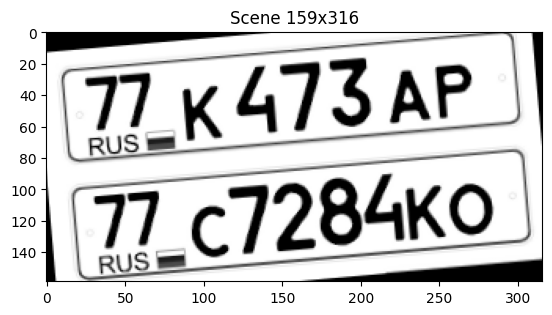

In [7]:
plt.imshow(img2, cmap='gray')
plt.title('Scene %dx%d' % img2.shape)

**Создадим функцию вычисляющую дескрипторы характерных точек ORB**
**Ищем характерные точки и вычисляем для них дескрипторы**

In [8]:
def get_ORB(img):
    # https://en.wikipedia.org/wiki/Oriented_FAST_and_rotated_BRIEF

    # инициализируем детектор точек
    orb = cv2.ORB_create()

    # запускаем поиск точек и вычисление дескрипторов
    kp1, des1 = orb.detectAndCompute(img, None)

    return kp1, des1

In [9]:
kp1, des1 = get_ORB(img1)
kp2, des2 = get_ORB(img2)

**Отобразим найденные характерные точки**

In [10]:
img1_kp = cv2.drawKeypoints(img1, kp1, np.zeros_like(img1))
plt.imshow(img1_kp)

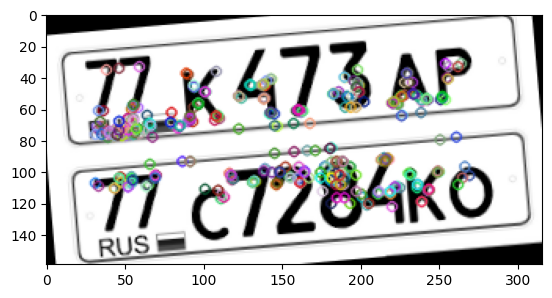

In [11]:
img2_kp = cv2.drawKeypoints(img2, kp2, np.zeros_like(img1))
plt.imshow(img2_kp)

**Создадим функцию выполняющей поиск соответствия между двумя изображениями на основе полного перебора**

In [12]:
def bf_matching(img1, kp1, img2, kp2):
    # матчинг полным перебором - brute force matching

    # мера расстояния - расстояние Хэмминга (количество несовпадающих компонент)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)

    # матчинг
    matches = bf.match(des1, des2)

    # сортируем результат по убыванию расстояния
    matches = sorted(matches, key = lambda x: x.distance)

    # выводим 10 лучших совпадений
    img3 = np.zeros_like(img2)
    img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:7], img3, flags=2)

    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.imshow(img3),plt.show()

In [13]:
kp1, des1 = get_ORB(img1)
kp2, des2 = get_ORB(img2)

**Создадим функцию выполняющей поиск соответствия между двумя изображениями на основе k-ближайших соседей**

In [14]:
def knn_matching(img1, kp1, img2, kp2):
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append([m])

    # cv2.drawMatchesKnn expects list of lists as matches.
    img3 = np.zeros_like(img2)
    img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,img3,flags=2)

    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.imshow(img3),plt.show()

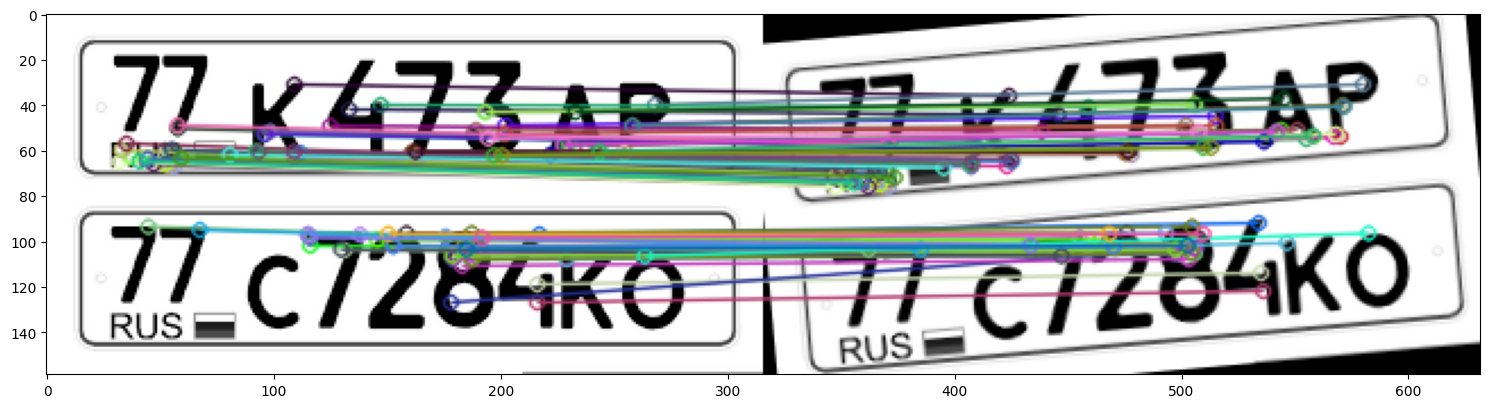

In [15]:
knn_matching(img1, kp1, img2, kp2)

## 2. Выполним сравнение двух изображений при наличии различий в масштабе

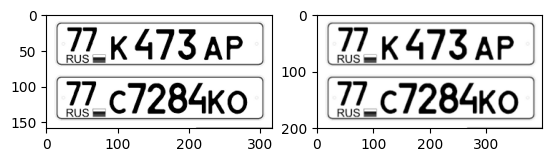

In [16]:
final_wide = 400
r = float(final_wide) / img1.shape[1]
dim = (final_wide, int(img1.shape[0] * r))

# уменьшаем изображение до подготовленных размеров
img4 = cv2.resize(img1, dim, interpolation = cv2.INTER_AREA)

plt.subplot(121)
plt.imshow(img1, cmap='gray')
plt.subplot(122)
plt.imshow(img4, cmap='gray')

In [17]:
# запускаем поиск точек и вычисление дескрипторов
kp1, des1 = get_ORB(img1)
kp2, des2 = get_ORB(img4)

In [18]:
bf_matching(img1, kp1, img4, kp2)

In [19]:
knn_matching(img1, kp1, img4, kp2)

## 3a. Выполним сравнение двух изображений, одно из которых является частью другого (обрезанное изображение)

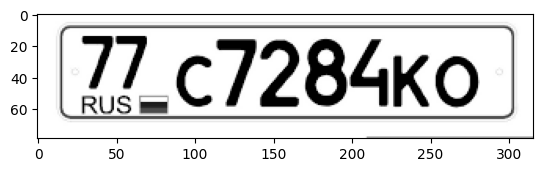

In [20]:
img5 = img1[80:, :]
plt.imshow(img5, cmap='gray')

In [21]:
# запускаем поиск точек и вычисление дескрипторов
kp1, des1 = get_ORB(img1)
kp2, des2 = get_ORB(img5)

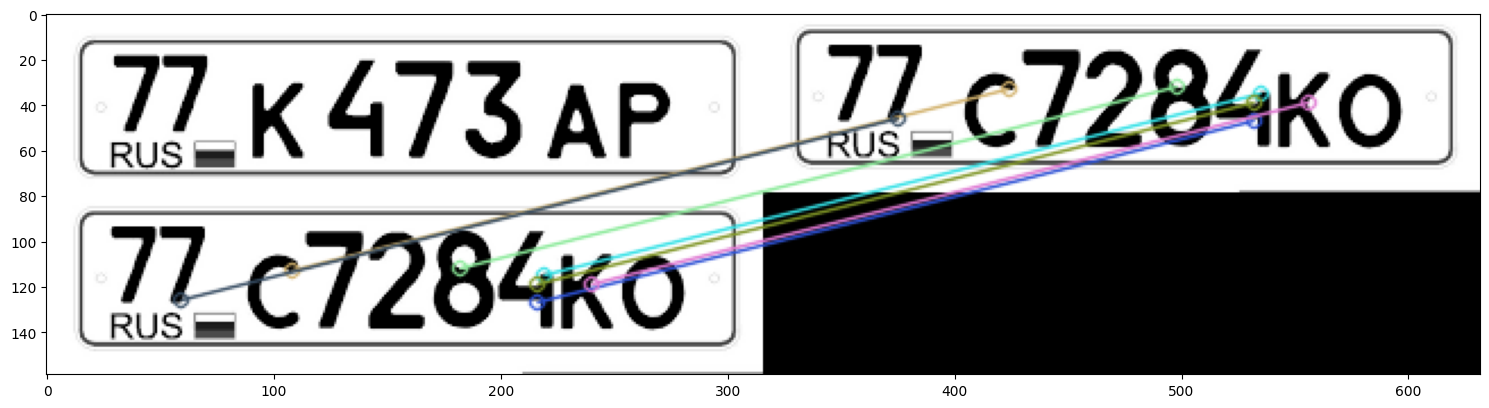

In [22]:
bf_matching(img1, kp1, img5, kp2)

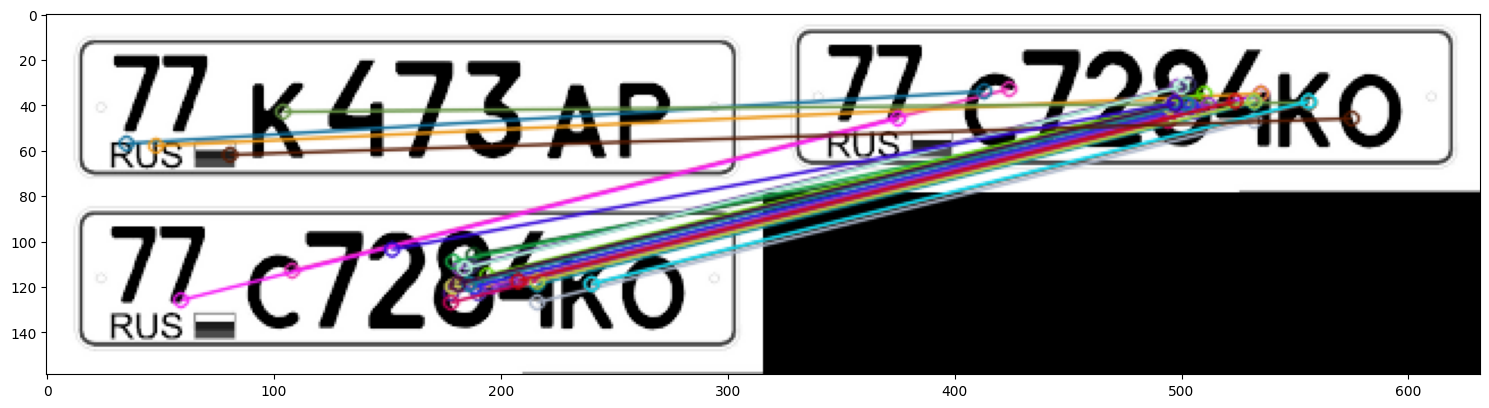

In [23]:
knn_matching(img1, kp1, img5, kp2)

## 3b. И для более сложных изображений

In [24]:
img1 = cv2.imread('/content/drive/MyDrive/Computer_vision/CV_labs/CV_lab_3/vangog0.jpg', cv2.IMREAD_GRAYSCALE)          # шаблон
img2 = cv2.imread('/content/drive/MyDrive/Computer_vision/CV_labs/CV_lab_3/vangog1.jpg', cv2.IMREAD_GRAYSCALE) # сцена

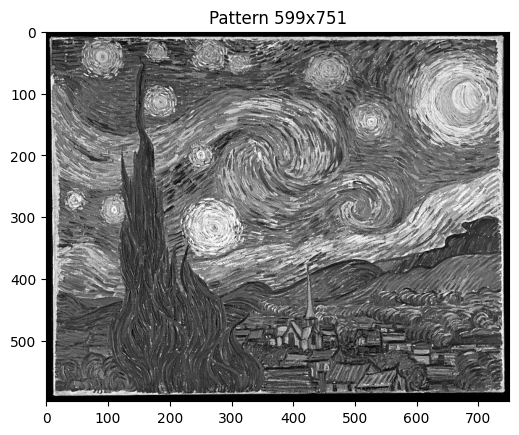

In [25]:
plt.imshow(img1, cmap='gray')
plt.title('Pattern %dx%d' % img1.shape);

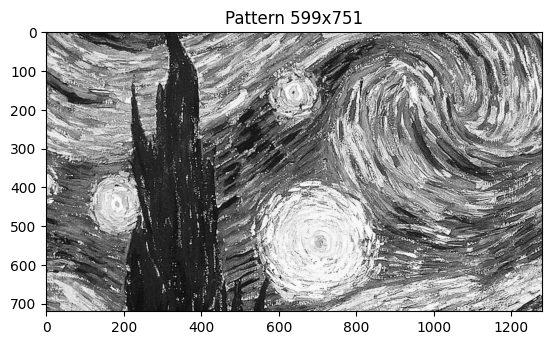

In [28]:
plt.imshow(img2, cmap='gray')
plt.title('Pattern %dx%d' % img1.shape);

In [29]:
# запускаем поиск точек и вычисление дескрипторов
kp1, des1 = get_ORB(img1)
kp2, des2 = get_ORB(img2)

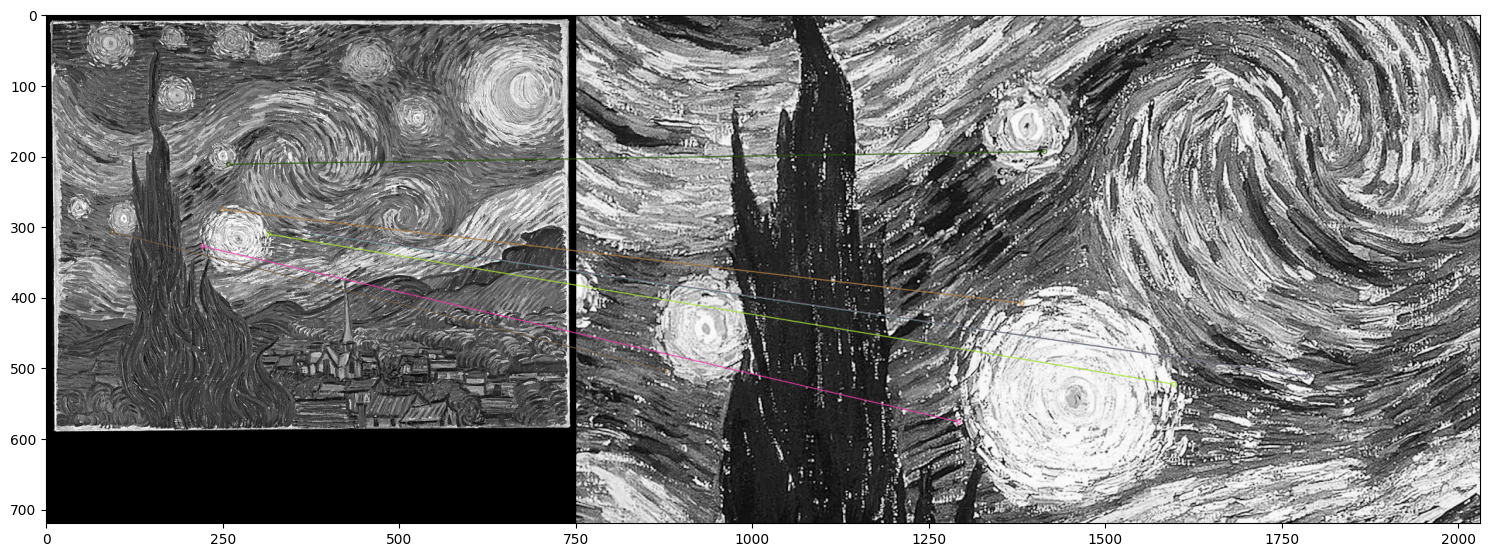

In [ ]:
bf_matching(img1, kp1, img2, kp2)

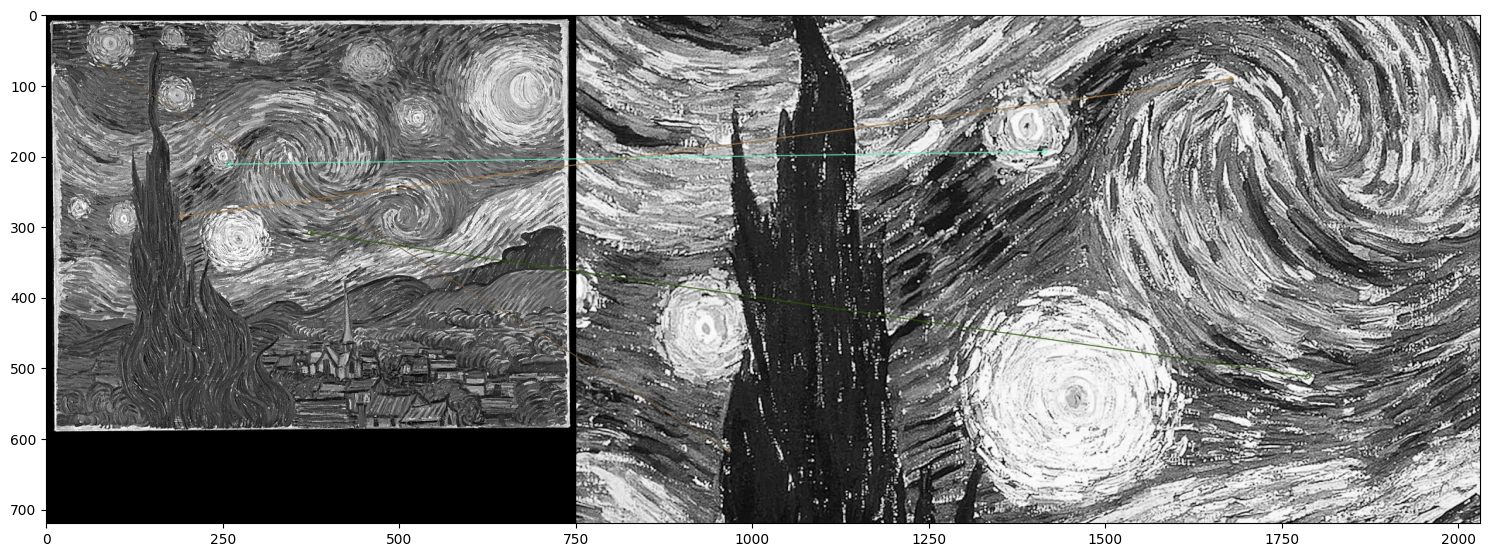

In [30]:
knn_matching(img1, kp1, img2, kp2)

# Задание.
Опираясь на справку ответьте на следующие вопросы:
- Что возвращает метод detectAndCompute()?
- Что возвращает метод drawKeypoints()?
- Что такое расстояние Хэмминга?
- Что такое дескриптор особых точек? Приведите примеры различных дескрипторов

**1. Что возвращает метод `detectAndCompute()`?**

Метод `detectAndCompute()` является комбинированным методом библиотеки OpenCV, который выполняет две основные операции за один проход по изображению:
*   **Обнаружение ключевых точек (Detection):** Находит в изображении особые точки (углы, центры blob-ов и т.д.), которые являются уникальными и легко сопоставимыми. Эти точки описываются своими координатами (x, y), размером, углом поворота и другими параметрами.
*   **Вычисление дескрипторов (Description):** Для каждой найденной ключевой точки вычисляет ее дескриптор — числовой вектор, который характеризует текстуру изображения в окрестности этой точки.

**Возвращаемое значение:** Метод возвращает кортеж (tuple) из двух элементов:
*   `keypoints`: Список объектов типа `KeyPoint`, которые описывают найденные характерные точки.
*   `descriptors`: Массив NumPy (чаще всего типа `np.uint8`), где каждая строка — это дескриптор соответствующей ключевой точки. Количество строк равно количеству ключевых точек.

**2. Что возвращает метод `drawKeypoints()`?**

Метод `drawKeypoints()` визуализирует ключевые точки на исходном изображении.

**Возвращаемое значение:** Метод возвращает новое изображение (массив NumPy), которое является копией исходного изображения `src`, с нарисованными на нем ключевыми точками из списка `keypoints`. Стиль отображения точек (цвет, размер) можно задавать с помощью дополнительных параметров.

**3. Что такое расстояние Хэмминга?**

**Расстояние Хэмминга** — это метрика, которая измеряет разницу между двумя **бинарными** строками (векторами) одинаковой длины. Оно определяется как **количество позиций, в которых соответствующие биты (символы) двух строк различаются**.

*   **Пример:** Для двух строк `1011101` и `1001001` расстояние Хэмминга равно 2, так как биты различаются в 3-й и 5-й позициях.
*   **Применение в компьютерном зрении:** Дескрипторы многих современных алгоритмов (ORB, BRIEF, BRISK, FREAK) являются бинарными. Это означает, что они представляют собой последовательности 0 и 1. Поэтому расстояние Хэмминга — это естественный и очень быстрый (вычисляется с помощью операции XOR и подсчета битов) способ сравнения таких дескрипторов при поиске соответствий.

**4. Что такое дескриптор особых точек? Приведите примеры различных дескрипторов.**

**Дескриптор особых (ключевых) точек** — это числовое представление области изображения вокруг обнаруженной ключевой точки. Его цель — уникально и устойчиво описать эту область так, чтобы одно и то же место на разных изображениях (при разных условиях освещения, ракурса, масштаба) имело похожие дескрипторы.

**Основные требования к дескриптору:**
*   **Уникальность:** Разные области должны иметь разные дескрипторы.
*   **Устойчивость (робастность):** Дескриптор должен быть инвариантен (или ковариантен) к изменениям масштаба, поворота, освещенности, небольшим изменениям ракурса.

**Примеры различных дескрипторов:**

1.  **SIFT (Scale-Invariant Feature Transform):**
    *   **Тип:** Небинарный, вещественнозначный (на основе градиентов).
    *   **Описание:** Создает гистограммы направлений градиентов в окрестности точки. Очень устойчивый, но относительно медленный.
    *   **Метрика для сравнения:** Евклидово расстояние (L2).

2.  **SURF (Speeded-Up Robust Features):**
    *   **Тип:** Небинарный, вещественнозначный.
    *   **Описание:** Ускоренная аппроксимация SIFT, использующая фильтры Хаара.
    *   **Метрика для сравнения:** Евклидово расстояние (L2).

3.  **ORB (Oriented FAST and Rotated BRIEF) - использован в работе:**
    *   **Тип:** Бинарный.
    *   **Описание:** Комбинирует детектор точек FAST с вычислением ориентации и дескриптором BRIEF, делая его устойчивым к повороту.
    *   **Метрика для сравнения:** Расстояние Хэмминга.

4.  **BRIEF (Binary Robust Independent Elementary Features):**
    *   **Тип:** Бинарный.
    *   **Описание:** Предшественник ORB. Сравнивает интенсивности пикселей в случайных парах точек вокруг ключевой точки. Не устойчив к повороту.
    *   **Метрика для сравнения:** Расстояние Хэмминга.

5.  **BRISK (Binary Robust Invariant Scalable Keypoints):**
    *   **Тип:** Бинарный.
    *   **Описание:** Использует специальный шаблон из концентрических окружностей для выборки пикселей, что делает его устойчивым к масштабу.
    *   **Метрика для сравнения:** Расстояние Хэмминга.

6.  **FREAK (Fast Retina Keypoint):**
    *   **Тип:** Бинарный.
    *   **Описание:** Вдохновлен человеческим глазом (сетчаткой). Использует sampling-паттерн, где плотность выборки выше near центра точки.
    *   **Метрика для сравнения:** Расстояние Хэмминга.

# Задание.
- Соберите коллекцию из 12 изображений различных картин художников (с повторением произведений, но все изображения должны быть разными)
- Создайте массив (список) из собранных изоборажений (по имени файла)
- Создайте несколько функций, позволяющих выполнять поиск для заданного изображения наиболее похожего изображения из коллекции, используя количество совпавших дескрипторов особых точек
- Протестируйте работу функций


# 1. Загружаем коллекцию изображений из папки

In [49]:
import os

def load_image_collection(folder_path):
    """Загружает коллекцию изображений из указанной папки"""
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    image_files.sort()

    images = []
    filenames = []

    for filename in image_files:
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
            filenames.append(filename)
            print(f"Загружено: {filename} - размер: {img.shape}")
        else:
            print(f"Ошибка загрузки: {filename}")

    return images, filenames

# Загружаем коллекцию
folder_path = '/content/drive/MyDrive/Computer_vision/CV_labs/CV_lab_3/Pictures/Tri_bogatirya'
collection_images, collection_filenames = load_image_collection(folder_path)

print(f"\nВсего загружено изображений: {len(collection_images)}")

Загружено: Tri_bogatirya1.jpg - размер: (3024, 4032)
Загружено: Tri_bogatirya10.jpg - размер: (660, 1024)
Загружено: Tri_bogatirya11.jpg - размер: (720, 540)
Загружено: Tri_bogatirya12.jpg - размер: (513, 845)
Загружено: Tri_bogatirya2.jpg - размер: (900, 1200)
Загружено: Tri_bogatirya3.jpg - размер: (1074, 1080)
Загружено: Tri_bogatirya4.jpg - размер: (960, 1280)
Загружено: Tri_bogatirya5.jpg - размер: (955, 720)
Загружено: Tri_bogatirya6.jpg - размер: (534, 800)
Загружено: Tri_bogatirya7.jpg - размер: (858, 1286)
Загружено: Tri_bogatirya8.jpg - размер: (812, 1200)
Загружено: Tri_bogatirya9.jpg - размер: (652, 869)

Всего загружено изображений: 12


# 2. Создаем функции для поиска похожих изображений

In [41]:
def extract_orb_features(img):
    """Извлекает ORB особенности из изображения"""
    orb = cv2.ORB_create(nfeatures=1000)
    kp, des = orb.detectAndCompute(img, None)
    return kp, des

def match_images_bf(query_des, train_des):
    """Сравнивает дескрипторы с помощью Brute-Force матчера"""
    if query_des is None or train_des is None:
        return 0

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(query_des, train_des)
    matches = sorted(matches, key=lambda x: x.distance)
    return len(matches)

def match_images_knn(query_des, train_des, ratio=0.75):
    """Сравнивает дескрипторы с помощью KNN матчера"""
    if query_des is None or train_des is None:
        return 0

    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = bf.knnMatch(query_des, train_des, k=2)

    # Применяем ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good_matches.append(m)

    return len(good_matches)

def find_similar_images(query_img, collection_images, collection_filenames, method='knn', top_k=3):
    """
    Находит наиболее похожие изображения в коллекции

    Parameters:
    - query_img: изображение для поиска
    - collection_images: список изображений коллекции
    - collection_filenames: список имен файлов коллекции
    - method: метод сравнения ('knn' или 'bf')
    - top_k: количество лучших результатов
    """

    # Извлекаем особенности запросного изображения
    query_kp, query_des = extract_orb_features(query_img)

    if query_des is None:
        print("Не удалось извлечь особенности из запросного изображения")
        return []

    scores = []

    # Сравниваем с каждым изображением в коллекции
    for i, (img, filename) in enumerate(zip(collection_images, collection_filenames)):
        train_kp, train_des = extract_orb_features(img)

        if train_des is None:
            score = 0
        else:
            if method == 'knn':
                score = match_images_knn(query_des, train_des)
            else:  # method == 'bf'
                score = match_images_bf(query_des, train_des)

        scores.append((filename, score, i))

    # Сортируем по убыванию количества совпадений
    scores.sort(key=lambda x: x[1], reverse=True)

    return scores[:top_k]

def display_results(query_img, results, collection_images, collection_filenames):
    """Отображает результаты поиска"""
    plt.figure(figsize=(15, 10))

    # Отображаем запросное изображение
    plt.subplot(2, len(results) + 1, 1)
    plt.imshow(query_img, cmap='gray')
    plt.title('Запросное изображение')
    plt.axis('off')

    # Отображаем результаты
    for i, (filename, score, idx) in enumerate(results):
        plt.subplot(2, len(results) + 1, i + 2)
        plt.imshow(collection_images[idx], cmap='gray')
        plt.title(f'{filename}\nСовпадений: {score}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 3. Тестируем работу функций
Тест 1: Используем первое изображение из коллекции как запрос


=== ТЕСТИРОВАНИЕ СИСТЕМЫ ПОИСКА ===

Тест 1: Поиск похожих для первого изображения коллекции
Запросное изображение: Tri_bogatirya.jpg

Результаты KNN метода:
  Tri_bogatirya.jpg: 1000 совпадений
  Tri_bogatirya3.jpg: 164 совпадений
  Tri_bogatirya2.jpg: 140 совпадений

Результаты BF метода:
  Tri_bogatirya.jpg: 1000 совпадений
  Tri_bogatirya10.jpg: 363 совпадений
  Tri_bogatirya3.jpg: 310 совпадений


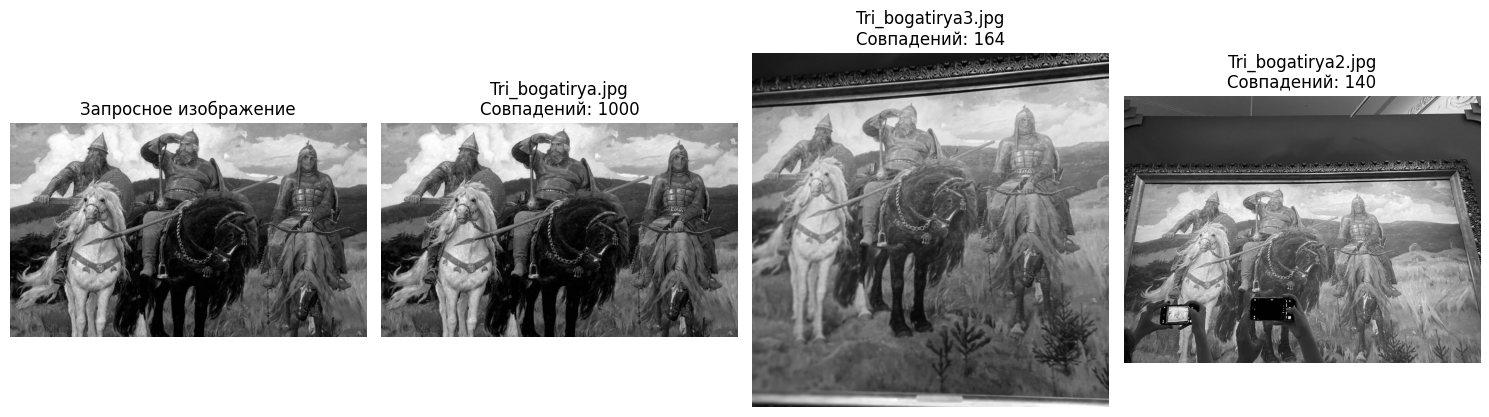

In [42]:
print("\n=== ТЕСТИРОВАНИЕ СИСТЕМЫ ПОИСКА ===\n")

# Тест 1: Используем первое изображение из коллекции как запрос
print("Тест 1: Поиск похожих для первого изображения коллекции")
query_img = collection_images[0]
query_name = collection_filenames[0]

print(f"Запросное изображение: {query_name}")

# Поиск методом KNN
results_knn = find_similar_images(query_img, collection_images, collection_filenames, method='knn', top_k=3)
print("\nРезультаты KNN метода:")
for filename, score, idx in results_knn:
    print(f"  {filename}: {score} совпадений")

# Поиск методом BF
results_bf = find_similar_images(query_img, collection_images, collection_filenames, method='bf', top_k=3)
print("\nРезультаты BF метода:")
for filename, score, idx in results_bf:
    print(f"  {filename}: {score} совпадений")

# Визуализация результатов KNN
display_results(query_img, results_knn, collection_images, collection_filenames)

Тест 2: Создаем модифицированную версию изображения для теста


Тест 2: Поиск с модифицированным изображением (поворот)
Результаты для повернутого изображения:
  Tri_bogatirya10.jpg: 706 совпадений
  Tri_bogatirya.jpg: 138 совпадений
  Tri_bogatirya3.jpg: 96 совпадений


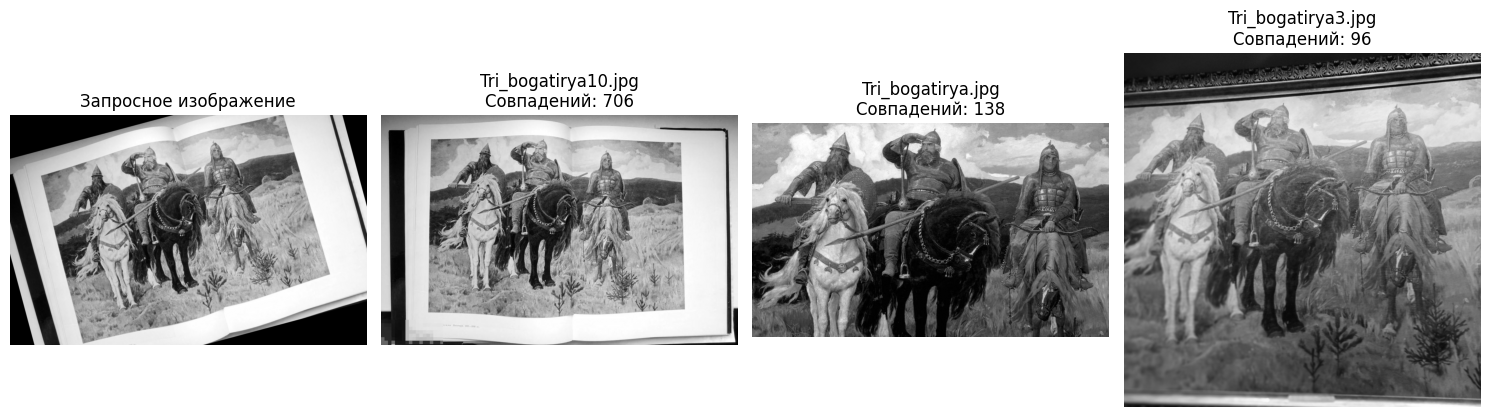

In [43]:
print("\nТест 2: Поиск с модифицированным изображением (поворот)")

# Создаем повернутую версию одного из изображений
(h, w) = collection_images[2].shape[:2]
center = (w / 2, h / 2)
M = cv2.getRotationMatrix2D(center, 15, 1.0)
rotated_img = cv2.warpAffine(collection_images[2], M, (w, h))

results_rotated = find_similar_images(rotated_img, collection_images, collection_filenames, method='knn', top_k=3)
print("Результаты для повернутого изображения:")
for filename, score, idx in results_rotated:
    print(f"  {filename}: {score} совпадений")

display_results(rotated_img, results_rotated, collection_images, collection_filenames)

Тест 3: Поиск для уменьшенного изображения


Тест 3: Поиск для уменьшенного изображения
Результаты для уменьшенного изображения:
  Tri_bogatirya11.jpg: 23 совпадений
  Tri_bogatirya6.jpg: 19 совпадений
  Tri_bogatirya9.jpg: 9 совпадений


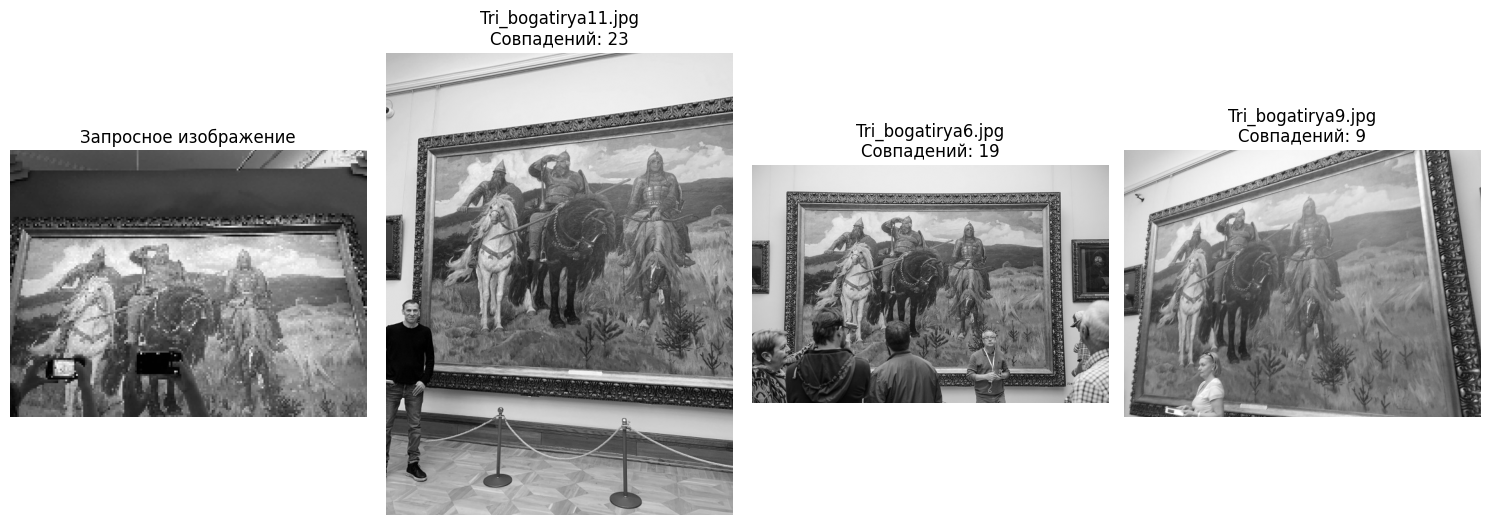

In [44]:
print("\nТест 3: Поиск для уменьшенного изображения")

# Уменьшаем изображение
small_img = cv2.resize(collection_images[4], (200, 150))

results_small = find_similar_images(small_img, collection_images, collection_filenames, method='knn', top_k=3)
print("Результаты для уменьшенного изображения:")
for filename, score, idx in results_small:
    print(f"  {filename}: {score} совпадений")

display_results(small_img, results_small, collection_images, collection_filenames)

# 4. Функция для интерактивного тестирования



In [50]:
def interactive_test():
    """Интерактивная функция для тестирования любого изображения из коллекции"""
    print("\n=== ИНТЕРАКТИВНОЕ ТЕСТИРОВАНИЕ ===")
    print("Доступные изображения в коллекции:")
    for i, filename in enumerate(collection_filenames):
        print(f"{i}: {filename}")

    try:
        choice = int(input("\nВведите номер изображения для тестирования (0-{}): ".format(len(collection_filenames)-1)))
        if 0 <= choice < len(collection_filenames):
            query_img = collection_images[choice]
            query_name = collection_filenames[choice]

            print(f"\nТестируем изображение: {query_name}")

            # Сравниваем оба метода
            results_knn = find_similar_images(query_img, collection_images, collection_filenames, method='knn', top_k=5)
            results_bf = find_similar_images(query_img, collection_images, collection_filenames, method='bf', top_k=5)

            print("\nТоп-5 результатов KNN:")
            for i, (filename, score, idx) in enumerate(results_knn):
                print(f"{i+1}. {filename}: {score} совпадений")

            print("\nТоп-5 результатов BF:")
            for i, (filename, score, idx) in enumerate(results_bf):
                print(f"{i+1}. {filename}: {score} совпадений")

            # Визуализируем лучшие результаты KNN
            display_results(query_img, results_knn, collection_images, collection_filenames)

        else:
            print("Неверный номер изображения")
    except ValueError:
        print("Пожалуйста, введите корректный номер")

# Запускаем интерактивное тестирование
interactive_test()


=== ИНТЕРАКТИВНОЕ ТЕСТИРОВАНИЕ ===
Доступные изображения в коллекции:
0: Tri_bogatirya1.jpg
1: Tri_bogatirya10.jpg
2: Tri_bogatirya11.jpg
3: Tri_bogatirya12.jpg
4: Tri_bogatirya2.jpg
5: Tri_bogatirya3.jpg
6: Tri_bogatirya4.jpg
7: Tri_bogatirya5.jpg
8: Tri_bogatirya6.jpg
9: Tri_bogatirya7.jpg
10: Tri_bogatirya8.jpg
11: Tri_bogatirya9.jpg

Введите номер изображения для тестирования (0-11): 3

Тестируем изображение: Tri_bogatirya12.jpg

Топ-5 результатов KNN:
1. Tri_bogatirya12.jpg: 1000 совпадений
2. Tri_bogatirya11.jpg: 19 совпадений
3. Tri_bogatirya10.jpg: 17 совпадений
4. Tri_bogatirya6.jpg: 17 совпадений
5. Tri_bogatirya4.jpg: 13 совпадений

Топ-5 результатов BF:
1. Tri_bogatirya12.jpg: 1000 совпадений
2. Tri_bogatirya10.jpg: 292 совпадений
3. Tri_bogatirya2.jpg: 262 совпадений
4. Tri_bogatirya5.jpg: 256 совпадений
5. Tri_bogatirya6.jpg: 247 совпадений


# 5. Анализ эффективности методов

In [47]:
print("\n=== АНАЛИЗ ЭФФЕКТИВНОСТИ МЕТОДОВ ===")

# Тестируем на нескольких изображениях
test_indices = [0, 2, 4]  # индексы изображений для теста

for idx in test_indices:
    query_img = collection_images[idx]
    query_name = collection_filenames[idx]

    results_knn = find_similar_images(query_img, collection_images, collection_filenames, method='knn', top_k=1)
    results_bf = find_similar_images(query_img, collection_images, collection_filenames, method='bf', top_k=1)

    knn_best = results_knn[0][0] if results_knn else "нет результатов"
    bf_best = results_bf[0][0] if results_bf else "нет результатов"

    print(f"\nИзображение: {query_name}")
    print(f"  KNN лучший результат: {knn_best}")
    print(f"  BF лучший результат: {bf_best}")
    print(f"  Совпадение с самим собой: {knn_best == query_name and bf_best == query_name}")

print("\n=== ТЕСТИРОВАНИЕ ЗАВЕРШЕНО ===")


=== АНАЛИЗ ЭФФЕКТИВНОСТИ МЕТОДОВ ===

Изображение: Tri_bogatirya.jpg
  KNN лучший результат: Tri_bogatirya.jpg
  BF лучший результат: Tri_bogatirya.jpg
  Совпадение с самим собой: True

Изображение: Tri_bogatirya10.jpg
  KNN лучший результат: Tri_bogatirya10.jpg
  BF лучший результат: Tri_bogatirya10.jpg
  Совпадение с самим собой: True

Изображение: Tri_bogatirya2.jpg
  KNN лучший результат: Tri_bogatirya2.jpg
  BF лучший результат: Tri_bogatirya2.jpg
  Совпадение с самим собой: True

=== ТЕСТИРОВАНИЕ ЗАВЕРШЕНО ===
